# Library Imports

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Utils

In [151]:
def data_preprocessing(data, holidays_events_data, stores_data, transactions_data, oil_data):

    stores_data['country'] = 'Ecuador'

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Regional']

    df2 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['state'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'Local']
    df22 = pd.merge(df_temp, stores_data, 
                left_on= 'locale_name',
                right_on=['city'], 
                how='left')

    df_temp = holidays_events_data[holidays_events_data['locale'] == 'National']
    df222 = pd.merge(df_temp, stores_data, 
                    how='left',
                    left_on= 'locale_name',
                    right_on=['country'])
    df = pd.concat([df2, df22, df222], ignore_index=True)

    df.rename(columns={"type_x": "holiday_type",
                    "type_y": "store_type"}, inplace=True)

    df.drop(columns=['description', 'locale', 
                    'locale_name', 'city','state','store_type','cluster','country' ], inplace=True)


    df = pd.merge(data, df, 
                on = ['date', 'store_nbr'], 
                how='left')

    df = pd.merge(df, transactions_data,
                    on=['date', 'store_nbr'],
                    how='left')

    df = pd.merge(df, stores_data,
                    on='store_nbr',
                    how='left')

    df = pd.merge(df, oil_data,
                    on='date',
                    how='left')

    df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
    df['is_wage_day'] = df['date'].apply(lambda x: True if x.day == 15 or x.day == x.days_in_month else False)

    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
    df['transferred'] = df['transferred'].fillna(False)
    df['is_holiday'] = ~df['holiday_type'].isna()
    df['is_open'] = ~df['transactions'].isna()
    df['is_really_holiday'] = df['is_holiday'] & ~df['is_open']

    df['transactions'] = df['transactions'].fillna(0)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df.drop(columns=['date', 'country'], inplace=True)

    le = LabelEncoder()

    df['family'] = le.fit_transform(df['family'])
    df['type'] = le.fit_transform(df['type'])
    df['holiday_type'] = le.fit_transform(df['holiday_type'])
    df['city'] = le.fit_transform(df['city'])
    df['state'] = le.fit_transform(df['state'])

    df['is_open'] = df['is_open'].astype(int)
    df['is_holiday'] = df['is_holiday'].astype(int)
    df['is_really_holiday'] = df['is_really_holiday'].astype(int)
    df['transferred'] = df['transferred'].astype(int)

    return df

# Data loading and first impressions

In [96]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
stores_data = pd.read_csv('data/stores.csv')
transactions_data = pd.read_csv('data/transactions.csv')
oil_data = pd.read_csv('data/oil.csv')
holidays_events_data = pd.read_csv('data/holidays_events.csv')

train_data['date'] = pd.to_datetime(train_data['date'])
holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

oil_data['dcoilwtico'][0] = 93.14

print(train_data.head())
print(stores_data.head())
print(transactions_data.head())
print(oil_data.head())
print(holidays_events_data.head())


0
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 20

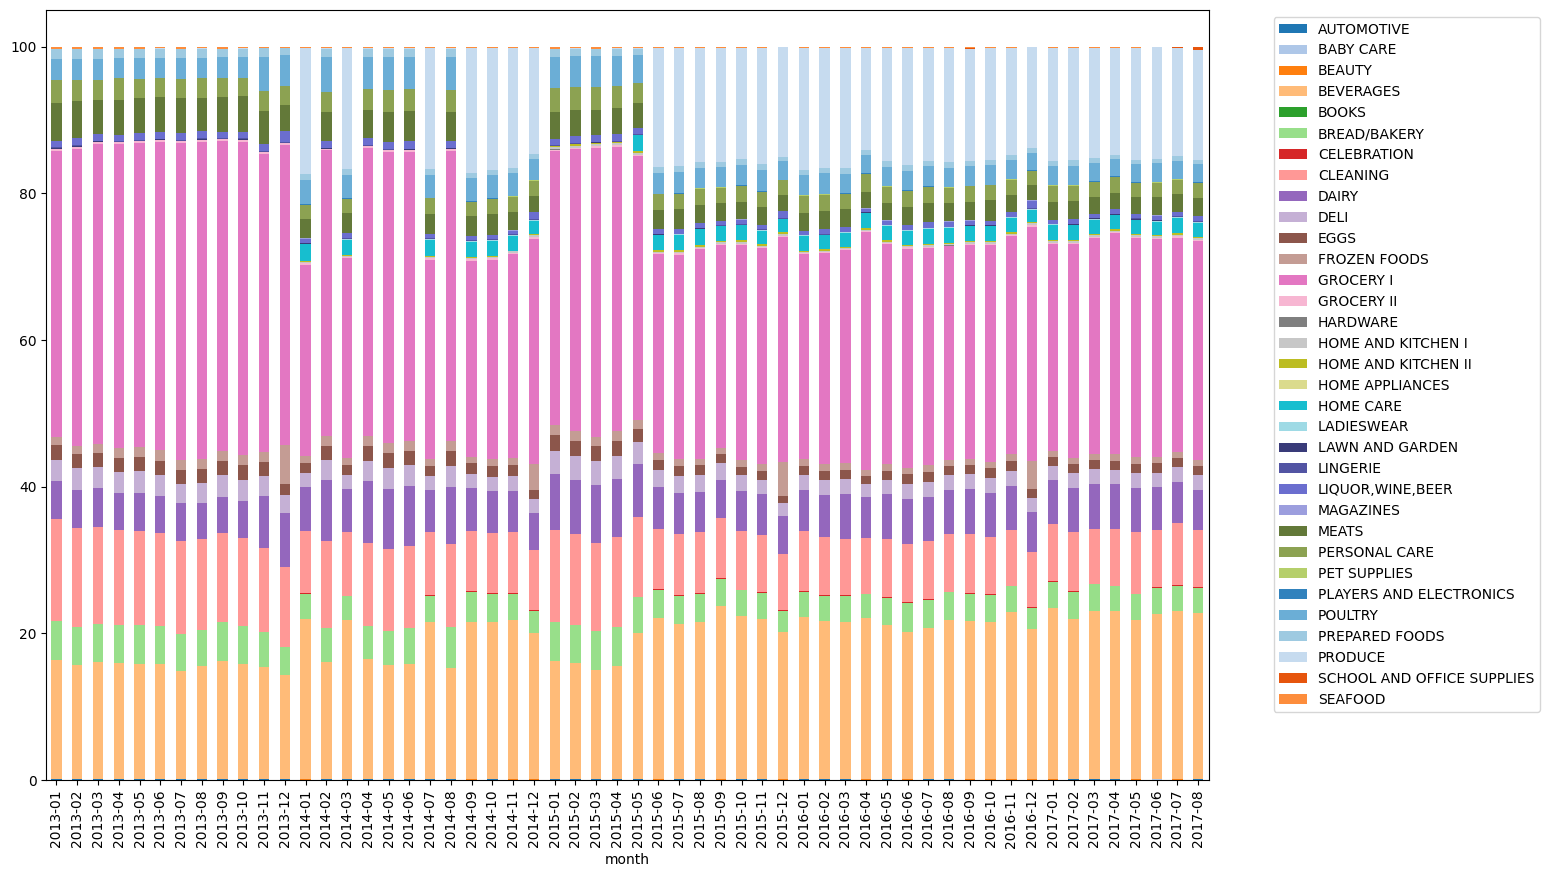

In [73]:

train_data['month'] = train_data['date'].dt.to_period('M')
grouped = train_data.groupby(['month', 'family'])['sales'].sum().reset_index()
grouped['percentage'] = grouped.groupby('month')['sales'].transform(lambda x: x / x.sum() * 100)

pivot_df = grouped.pivot(index='month', columns='family', values='percentage')
pivot_df.index = pivot_df.index.astype(str)
colors = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 7) + sns.color_palette("tab20c", 6)
pivot_df.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


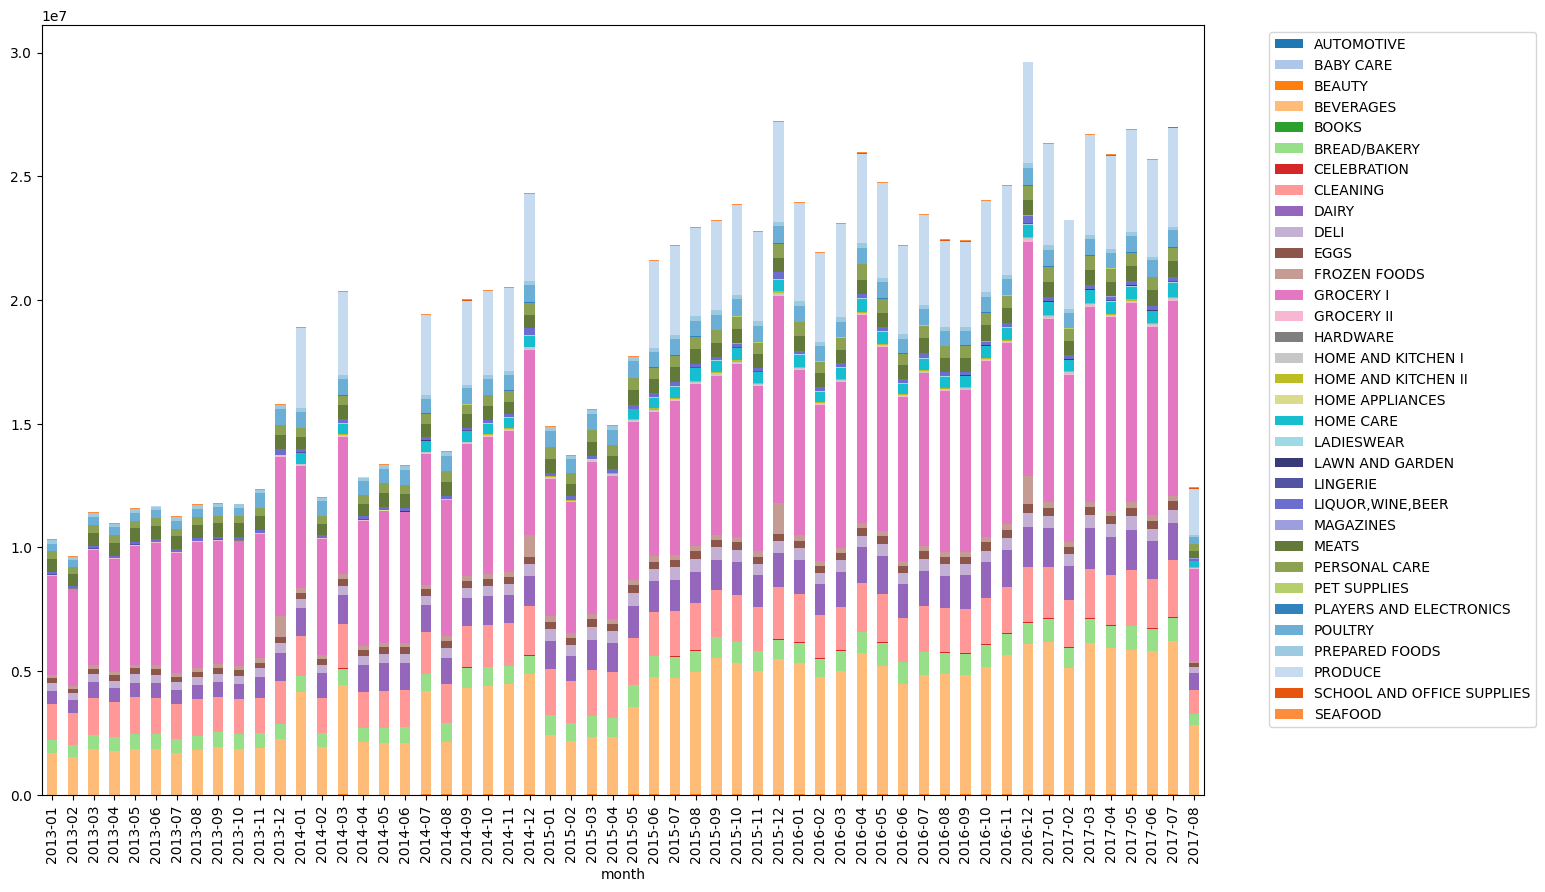

In [74]:
grouped = train_data.groupby(['month', 'family'])['sales'].sum().reset_index()

pivot_df = grouped.pivot(index='month', columns='family', values='sales')
pivot_df.index = pivot_df.index.astype(str)
colors = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 7) + sns.color_palette("tab20c", 6)
pivot_df.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Data preprocessing

In [113]:
df = data_preprocessing(train_data, holidays_events_data, stores_data, transactions_data, oil_data)
display(df.head(5))
print(df.isnull().sum())

,id,store_nbr,family,sales,onpromotion,holiday_type,transferred,transactions,city,state,type,cluster,dcoilwtico,is_wage_day,is_holiday,is_open,is_really_holiday,year,month,day
0,0,1,AUTOMOTIVE,0.0,0,Holiday,False,0.0,Quito,Pichincha,D,13,93.14,False,True,False,True,2013,1,1
1,1194,42,CELEBRATION,0.0,0,Holiday,False,0.0,Cuenca,Azuay,D,2,93.14,False,True,False,True,2013,1,1
2,1193,42,BREAD/BAKERY,0.0,0,Holiday,False,0.0,Cuenca,Azuay,D,2,93.14,False,True,False,True,2013,1,1
3,1192,42,BOOKS,0.0,0,Holiday,False,0.0,Cuenca,Azuay,D,2,93.14,False,True,False,True,2013,1,1
4,1191,42,BEVERAGES,0.0,0,Holiday,False,0.0,Cuenca,Azuay,D,2,93.14,False,True,False,True,2013,1,1


,id,store_nbr,family,sales,onpromotion,holiday_type,transferred,transactions,city,state,type,cluster,dcoilwtico,is_wage_day,is_holiday,is_open,is_really_holiday,year,month,day
0,0,1,0,0.0,0,3,0,0.0,18,12,3,13,93.14,False,1,0,1,2013,1,1
1,1194,42,6,0.0,0,3,0,0.0,3,0,3,2,93.14,False,1,0,1,2013,1,1
2,1193,42,5,0.0,0,3,0,0.0,3,0,3,2,93.14,False,1,0,1,2013,1,1
3,1192,42,4,0.0,0,3,0,0.0,3,0,3,2,93.14,False,1,0,1,2013,1,1
4,1191,42,3,0.0,0,3,0,0.0,3,0,3,2,93.14,False,1,0,1,2013,1,1


id                   0
store_nbr            0
family               0
sales                0
onpromotion          0
holiday_type         0
transferred          0
transactions         0
city                 0
state                0
type                 0
cluster              0
dcoilwtico           0
is_wage_day          0
is_holiday           0
is_open              0
is_really_holiday    0
year                 0
month                0
day                  0
dtype: int64


# Correlation Map

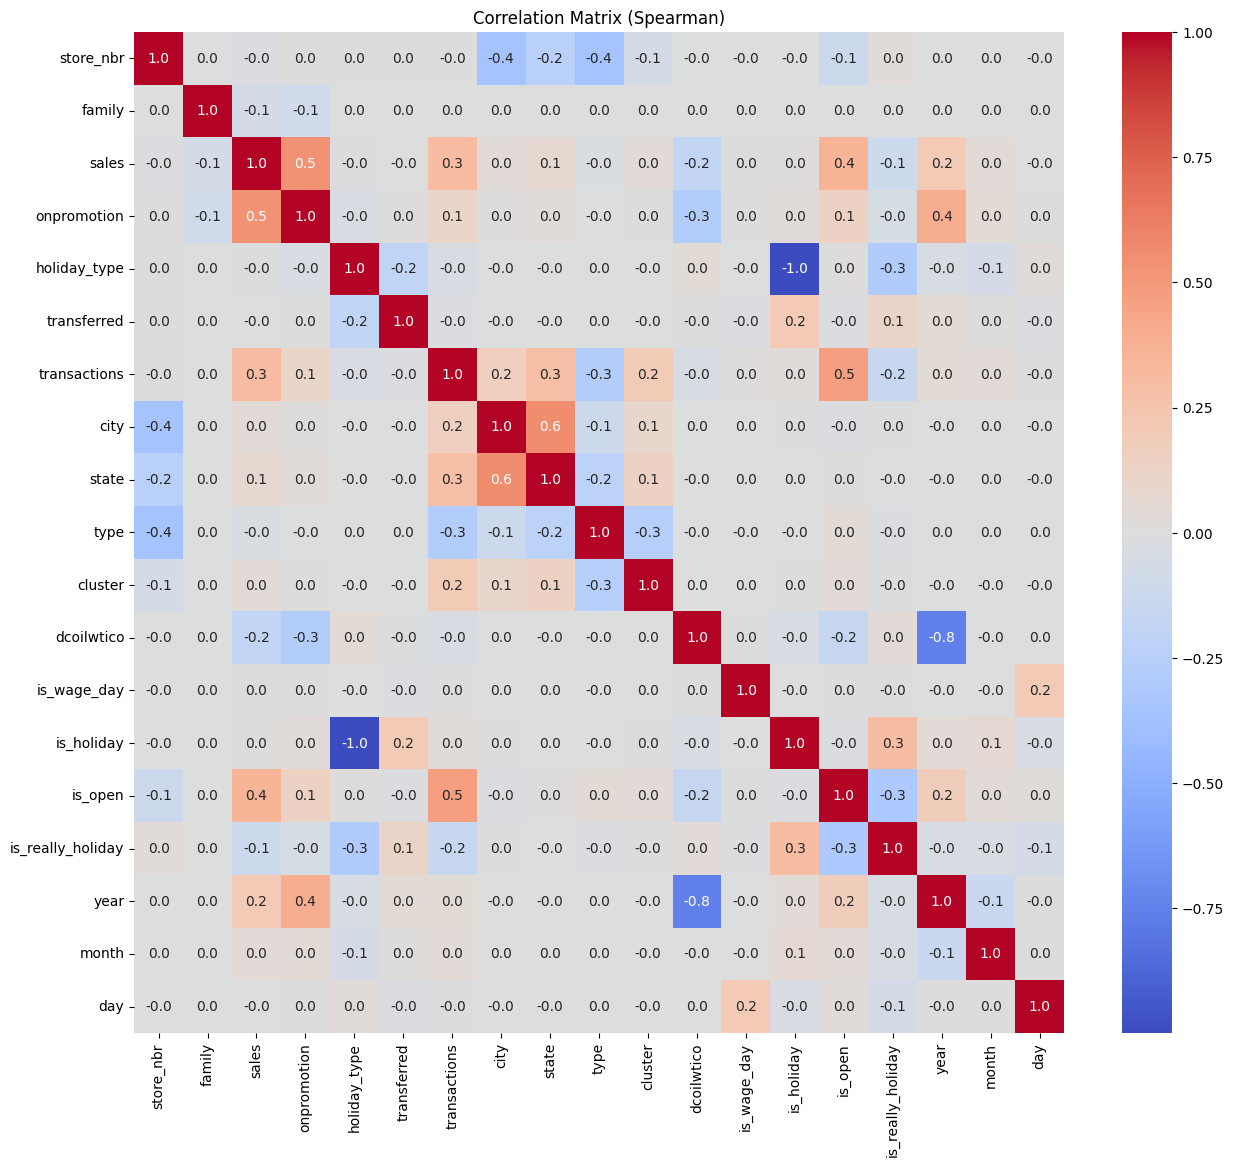

In [145]:
correlation_matrix_spearman = df.drop(columns=['id']).corr(method='spearman')

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix (Spearman)')
plt.show()

# First prediction: the total sales of a Store

In [132]:
train = df.drop(columns=['is_holiday', 'holiday_type', 'transferred', 'city',
                         'state','type','cluster','is_holiday','is_really_holiday', 'dcoilwtico', 'is_wage_day', 'is_open'])
display(train.head(5))
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

,id,store_nbr,family,sales,onpromotion,transactions,year,month,day
0,0,1,0,0.0,0,0.0,2013,1,1
1,1194,42,6,0.0,0,0.0,2013,1,1
2,1193,42,5,0.0,0,0.0,2013,1,1
3,1192,42,4,0.0,0,0.0,2013,1,1
4,1191,42,3,0.0,0,0.0,2013,1,1


In [133]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror'),
    Ridge(),
    Lasso()
]
model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [497.10780406 493.22137196 502.97816599 508.91932001 506.54842436]
Mean RMSE: 501.7550172755111

Model: DecisionTreeRegressor
RMSE Scores: [176.4943011  222.41284539 205.30281073 163.91610684 161.49550797]
Mean RMSE: 185.92431440659942

Model: RandomForestRegressor
RMSE Scores: [133.51935803 154.06740579 150.0841596  142.36876418 157.33423276]
Mean RMSE: 147.47478407254874

Model: XGBRegressor
RMSE Scores: [130.89332486 141.94511014 168.23163356 175.95618519 166.89311623]
Mean RMSE: 156.78387399485538

Model: Ridge
RMSE Scores: [497.10779381 493.2213678  502.97815702 508.91930171 506.54844002]
Mean RMSE: 501.7550120737483

Model: Lasso
RMSE Scores: [497.07376094 493.224924   502.97043031 508.89175739 506.56626082]
Mean RMSE: 501.745426693632



## Adding holiday information

In [143]:
train = df.drop(columns=['dcoilwtico', 'is_wage_day'])
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror'),
    Ridge(),
    Lasso()
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [496.9610033  492.9927565  503.6441693  508.75465227 506.49579027]
Mean RMSE: 501.76967432627106

Model: DecisionTreeRegressor
RMSE Scores: [165.6639169  228.13283816 170.5059181  191.53521524 163.53198768]
Mean RMSE: 183.87397521768827

Model: RandomForestRegressor
RMSE Scores: [130.76390377 152.74785888 146.55003244 140.97388639 157.4180614 ]
Mean RMSE: 145.69074857689847

Model: XGBRegressor
RMSE Scores: [131.65253885 159.22272473 168.0474661  179.68057333 163.31742828]
Mean RMSE: 160.38414625915067

Model: Ridge
RMSE Scores: [496.96276184 493.00233015 503.60481235 508.76135333 506.4852584 ]
Mean RMSE: 501.7633032141637

Model: Lasso
RMSE Scores: [497.08232334 493.19472351 503.17154192 508.86783381 506.53304885]
Mean RMSE: 501.76989428548785

Model: MLPRegressor
RMSE Scores: [482.79742162 465.36592416 487.20571125 483.55499547 481.22396967]
Mean RMSE: 480.02960443406835



## Adding oil barrel price information

In [138]:
train = df.drop(columns=['is_wage_day'])
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror'),
    Ridge(),
    Lasso()
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model

Model: LinearRegression
RMSE Scores: [496.56240031 493.01002671 503.57672489 508.48298107 506.74465672]
Mean RMSE: 501.67535793789966

Model: DecisionTreeRegressor
RMSE Scores: [158.73838135 249.66003915 179.32804106 183.46414528 177.3428519 ]
Mean RMSE: 189.70669174674532

Model: RandomForestRegressor
RMSE Scores: [128.74409932 147.18411232 154.18883921 140.57622073 158.59151513]
Mean RMSE: 145.85695734188903

Model: XGBRegressor
RMSE Scores: [129.60745752 141.8890563  175.20624833 155.41507323 163.08815021]
Mean RMSE: 153.0411971180196

Model: Ridge
RMSE Scores: [496.56311559 493.01811394 503.53964893 508.48880697 506.73572894]
Mean RMSE: 501.6690828741349

Model: Lasso
RMSE Scores: [496.7582826  493.15506758 503.10144371 508.59519517 506.75938803]
Mean RMSE: 501.67387541947664



## Add public wages day

In [140]:
train = df.copy()
train = train[train['store_nbr'] == 1].reset_index(drop=True)
train = train.drop(columns=['store_nbr'])

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(objective ='reg:squarederror'),
    Ridge(),
    Lasso()
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}\n")
    model_params[type(model).__name__] = model


Model: LinearRegression
RMSE Scores: [496.54707636 493.02685025 503.58478976 508.47359258 506.79167474]
Mean RMSE: 501.6847967406351

Model: DecisionTreeRegressor
RMSE Scores: [153.81458786 244.34545003 176.33568351 219.53488924 174.94173942]
Mean RMSE: 193.79447001169473

Model: RandomForestRegressor
RMSE Scores: [122.78802103 156.34654144 154.29470703 138.96805175 155.57138623]
Mean RMSE: 145.59374149533375

Model: XGBRegressor
RMSE Scores: [134.83059352 160.45189578 173.88325933 145.94267356 171.03004413]
Mean RMSE: 157.22769326656407

Model: Ridge
RMSE Scores: [496.54782566 493.03486155 503.54755401 508.47943922 506.78266937]
Mean RMSE: 501.6784699596774

Model: Lasso
RMSE Scores: [496.75828258 493.15506757 503.10144371 508.59519517 506.76241947]
Mean RMSE: 501.6744817017463



# Predicting sales for all stores

In [148]:
train = df.copy()

X = train.drop(columns= [ 'id','sales'], axis=1)
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    RandomForestRegressor()
]

model_params = {}
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {type(model).__name__}")
    print(f"RMSE Scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean()}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    model_params[type(model).__name__] = model

Model: RandomForestRegressor
RMSE Scores: [228.24632994 302.9379601  254.04990828 222.52837521 242.40463363]
Mean RMSE: 250.03344143299705
Mean Absolute Error: 48.48920332072641
R^2 Score: 0.9567527517708558


# Kaggle submission

,id,store_nbr,family,onpromotion,holiday_type,transferred,transactions,city,state,type,cluster,dcoilwtico,is_wage_day,is_holiday,is_open,is_really_holiday,year,month,day
0,3000888,1,0,0,1,0,0.0,18,12,3,13,46.8,False,0,0,0,2017,8,16
1,3000889,1,1,0,1,0,0.0,18,12,3,13,46.8,False,0,0,0,2017,8,16
2,3000890,1,2,2,1,0,0.0,18,12,3,13,46.8,False,0,0,0,2017,8,16
3,3000891,1,3,20,1,0,0.0,18,12,3,13,46.8,False,0,0,0,2017,8,16
4,3000892,1,4,0,1,0,0.0,18,12,3,13,46.8,False,0,0,0,2017,8,16


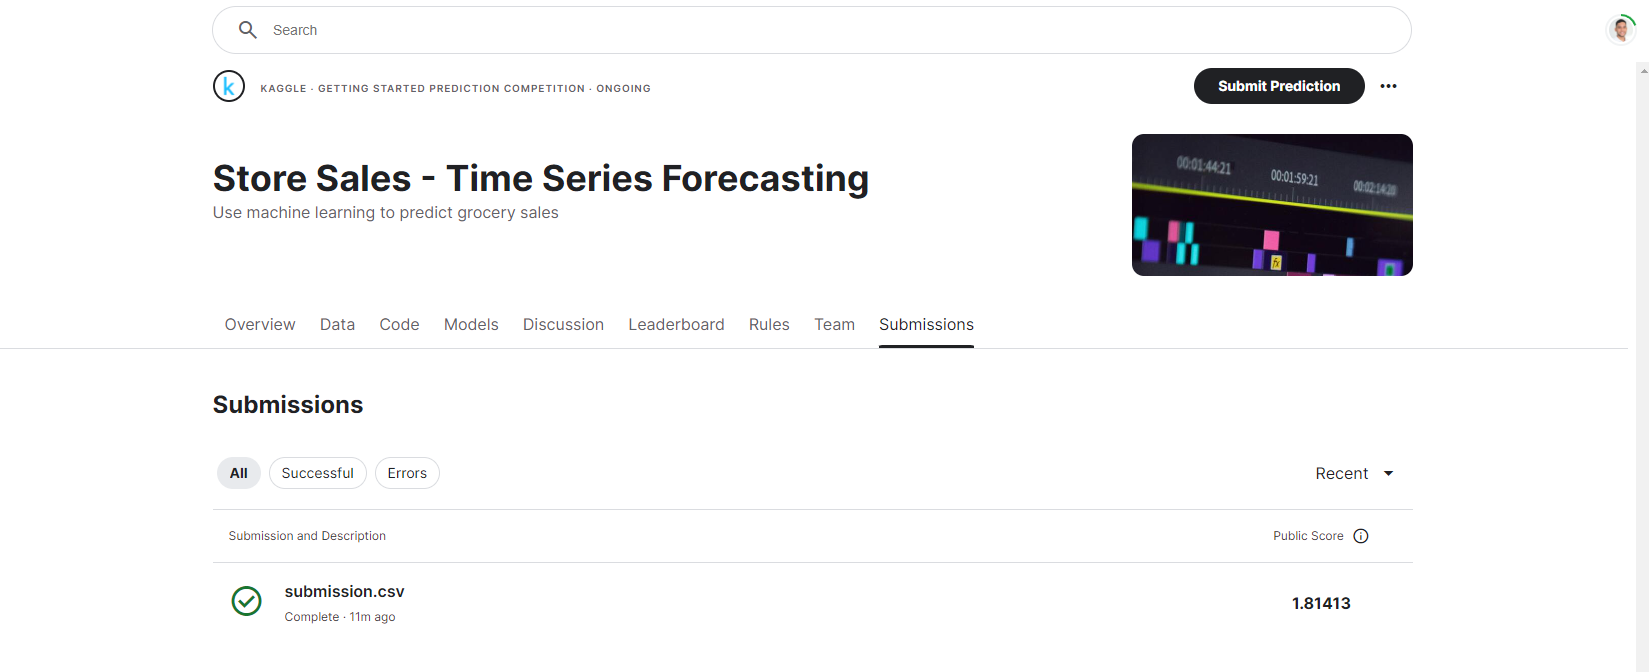

In [158]:
submission = data_preprocessing(test_data, holidays_events_data, stores_data, transactions_data, oil_data)
submission = submission.sort_values(by='id', ascending=True).reset_index(drop=True)

display(submission.head(5))

X_submission = submission.drop(columns=['id'])
model = model_params['RandomForestRegressor']
y_submission = model.predict(X_submission)
submission_file = pd.DataFrame({'id': submission['id'], 'sales': y_submission})
submission_file.to_csv('results/rf_results.csv', index=False)
Image(filename='images/kaggle-sales.png')
